In [1]:
import os
import pprint
import time

import numpy as np
import torch
from aml.plotting import TensorBoard, get_time,plot_to_image,bar_plot
import config
from SearchAlg.genetic_alg_general_functions import get_L, GetPhysicalLoss

from WinTermHelpers.query_helpers import *
from FileSystem.general_purpose_functions import *
from Alg.solving_algorithm import ModelGenerator
from FileSystem.storage import PStorage, SimResultsManager
from CustomModels.my_models import DistrMaker
from CustomModels.my_models import Integrator
import config
from general import plot_policy_function, plot_trajectories,get_sim_results,plot_policy_function_with_trajectories
from Simulation.sim_supp import make_psi, make_simulation_for_one_policy_function
import sys
from general_purpose_functions import time_mesuament
from inc_random_descent import insert_noise_to_p
import matplotlib.pyplot as plt
from config import theta_v_range, omega_v_range, F_v_range
from tqdm import tqdm
from numba import jit
from aml.plotting import *
import copy
from CustomModels.my_models import *

from general import plot_rect
from matplotlib import cm

In [2]:
N1 = 10
N2 = 10
M = 10
s1_step = (theta_v_range[1]-theta_v_range[0])/N1 
s2_step = (omega_v_range[1]-omega_v_range[0])/N2
a1_step = (F_v_range[1]-F_v_range[0])/M

s1_grid = np.linspace(start=theta_v_range[0],stop=theta_v_range[1],num = N1+1)
s2_grid = np.linspace(start=omega_v_range[0],stop=omega_v_range[1],num = N2+1)
a1_grid = np.linspace(start=F_v_range[0],stop=F_v_range[1],num = M+1)
s1_grid_si = np.array([config.translators_units_of_measurement['from_th_in_volt_to_th_in_si'](el) for el in s1_grid],dtype=np.float32)
s2_grid_si = np.array([config.translators_units_of_measurement['from_omega_in_volt_to_omega_in_si'](el) for el in s2_grid],dtype=np.float32)
a1_grid_si = np.array([config.translators_units_of_measurement['from_v_in_volt_to_v_in_si'](el) for el in a1_grid],dtype=np.float32)
s1_values = np.arange(start = theta_v_range[0]+s1_step/2,stop=theta_v_range[1],step= s1_step)
s2_values = np.arange(start = omega_v_range[0]+s2_step/2,stop=omega_v_range[1],step= s2_step)
a1_values = np.arange(start = F_v_range[0]+a1_step/2,stop=F_v_range[1],step= a1_step)

In [3]:
PI = torch.load(os.path.join(config.task_dir,'policy_ml_backup.txt'))


In [4]:
print(PI[0])

[3.9998105e-32 9.9999988e-01 1.6491267e-31 2.4202900e-30 6.2511003e-11
 8.1276196e-34 7.3029278e-18 9.9025141e-24 2.7968543e-35 8.1190469e-33]


In [5]:

p_ml = build_distrib3d_from_policy_matrix(build_p_from_policy_matrix(PI, N1,N2,M,s1_grid,s2_grid,a1_grid),
                                          s1_grid,s2_grid,a1_grid,N1*N2,M)
    

In [6]:
print(np.sum(p_ml.values*p_ml.volumes))
print(p_ml.values[0][0])
print(p_ml.values[0][1])
print(p_ml.values[0][2])
print(p_ml.values[0][3])

1.0
[4.9997630e-32 1.2499998e+00 2.0614083e-31 3.0253623e-30 7.8138752e-11
 1.0159524e-33 9.1286594e-18 1.2378142e-23 3.4960677e-35 1.0148808e-32]
[4.6882363e-31 6.7017372e-20 3.0778065e-01 9.4221938e-01 3.3237129e-31
 2.6735893e-35 5.3014410e-31 1.4425936e-32 2.2210108e-32 2.2178960e-32]
[1.6832724e-32 2.6064190e-01 5.0989053e-21 1.3112491e-34 1.3323947e-22
 9.4881994e-01 1.1210553e-33 2.0241699e-27 3.5156493e-30 4.0538132e-02]
[1.2499998e+00 2.5709847e-25 2.1632137e-30 1.5833905e-30 1.4331987e-23
 6.2228386e-33 1.8267547e-32 6.0084710e-33 1.4740579e-28 1.1247952e-31]


In [7]:
p_expert = torch.load(config.p_0_for_mixture_path)

In [8]:
p_experts = []
sum_0 = 0.0
for i in range(len(p_expert.np_omega)):
    grid_ = convert_segments_grid_to_grid(p_expert.np_omega[i])
    values_ = p_expert.z_list[i]
    volumes_ = compute_volumes_from_grid(grid_)
    sum_0 += np.sum(values_*volumes_)
    p_ = Distrib3D(grid_,values_,volumes_)
    p_experts.append(p_)
print(sum_0)

0.8918901992477244


In [9]:
p_exp = make_distrib_from_weighted_sum_of_distributions(p_experts,alpha_vec=np.ones(shape=(len(p_experts),),dtype=np.float32))

In [10]:
print(p_exp.values[0][0])

[2.3746212 1.6465049 1.5375555 1.2108303 0.6244743 0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.       ]


0.9999998


(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': '. n of unique values 8868'}, xlabel='nan rate 0.0'>)

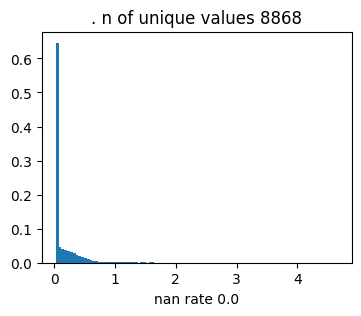

In [11]:
print(np.sum(p_exp.values*p_exp.volumes))
plot_float_distribution(p_exp.values.flatten())

In [12]:
print(len(p_exp.grid[0]))
print(len(p_exp.grid[1]))
print(len(p_exp.grid[2]))
print(p_exp.values.shape)
# print(p_exp.values[4][0])
# plot_float_distribution(p_exp.values.flatten())

31
31
31
(30, 30, 30)


In [13]:
print(p_ml.grid[0].shape)
print(p_ml.grid[1].shape)
print(p_ml.grid[2].shape)
print(p_ml.values.shape)

(11,)
(11,)
(11,)
(10, 10, 10)


In [14]:
S_0 = []
for i in range(N1):
    for j in range(N2):
        S_0.append((s1_values[i],s2_values[j]))

In [15]:

@jit(nopython = True)
def L(solution:np.array,rho_max:float,gamma:float,tau:float,t_end:float)->float:
    theta_vec = solution[:,0]
    omega_vec = solution[:,1]
    T_ = len(theta_vec)
    rho_i = np.sqrt(np.square(theta_vec) + np.square(omega_vec))
    # theta_i = np.absolute(theta_vec)
    # delta_rho_i = np.diff(rho_i)
    # delta_theta_i = -np.diff(np.absolute(theta_vec))
    # delta_omega_i = -np.diff(np.absolute(omega_vec))
    r_vec = np.zeros(shape=(T_-1,),dtype=np.float32)
    for t in range(1, T_):
        r_vec[t-1] = 1/(rho_i[t]*np.absolute(t*tau/t_end)+0.001)
        # r_vec[t-1] = -rho_i[t]*np.absolute(t*tau/t_end)
        # r_vec[t-1] = -theta_i[t]*np.absolute(t*tau/t_end)/T_
        # r_vec[t-1]  = (theta_i[t-1] - theta_i[t])
    # r_vec =  r_vec*(1.0/T_)
    r_vec =  r_vec*T_
    # r_vec = r_vec * (1.0/theta_i[0]) 
    # simple_plot(np.arange(0,T_),rho_i,title=r'$\rho$',size=(5,5))
    # fig,ax = simple_plot(np.arange(1,T_),-r_vec,title=r'$loss$',size=(5,5))
    # ax.set_xlim(0,T_-1)
    # # simple_plot(np.arange(1,T_),delta_rho_i,title=r'$\delta_{rho}$',size=(5,5))
    # # plot_float_distribution(r_vec)
    # raise SystemExit
    return -r_vec
def plot_trajectories_at_axis(ax, trajectories,colors,alpha):
    for i in range(len(trajectories)):
        tr = trajectories[i]
        th = tr[:,0]
        omega = tr[:,1]
        ax.plot(th,omega,c=colors[i],alpha=alpha[i])
    return ax

In [18]:
alpha_i = np.linspace(start=0, stop=0.99,num=10)
total_loss_vec = np.zeros(shape=(len(alpha_i),))
rho_max_ = np.sqrt(config.fuzzy_inf_params['th_max']**2 + config.fuzzy_inf_params['omega_max']**2)
gamma_ = 0.99
for l in range(len(alpha_i)):
    alpha = alpha_i[l]
    p_mix = make_distrib_from_weighted_sum_of_distributions([p_exp,p_ml], alpha_vec=[alpha, 1-alpha])
    def policy(x_1,x_2):
        # return p_mix.math_expectation(x_1,x_2)
        return p_mix.random_choice(x_1,x_2)

    
    from_th_in_volt_to_th_in_si = config.translators_units_of_measurement['from_th_in_volt_to_th_in_si']
    from_omega_in_volt_to_omega_in_si = config.translators_units_of_measurement['from_omega_in_volt_to_omega_in_si']
    from_th_in_si_to_th_in_volt = config.translators_units_of_measurement['from_th_in_si_to_th_in_volt']
    from_omega_in_si_to_omega_in_volt = config.translators_units_of_measurement['from_omega_in_si_to_omega_in_volt']
    from_v_in_volt_to_v_in_si = config.translators_units_of_measurement['from_v_in_volt_to_v_in_si']
    def policy_si(x1,x2):
        # return from_v_in_volt_to_v_in_si(p_mix.math_expectation(from_th_in_si_to_th_in_volt(x1),from_omega_in_si_to_omega_in_volt(x2)))
        return from_v_in_volt_to_v_in_si(p_mix.random_choice(from_th_in_si_to_th_in_volt(x1),from_omega_in_si_to_omega_in_volt(x2)))
    
    condition_of_break = np.asarray([
    config.theta_range,
    config.omega_range,
    [-9999.0, 9999.0],
    [-9999.0, 9999.0]
    ])
    simulation = make_simulation_for_one_policy_function(
        psi=policy_si,
        phys_sim_params=config.phys_sim_params,
        condition_of_break=condition_of_break,
        object_params=config.phys_params,
        use_an_early_stop=False,
        action_check=False
        
    )
    T = config.phys_sim_params['t_end']
    tau = config.phys_sim_params['tau']
    y_0 = config.phys_sim_params['y_0']
    v_0 = config.phys_sim_params['v_0']
    trajectories = []
    trajectories_v = []
    colors = []
    alphas = []
    L_vec_ = np.zeros(shape=(len(S_0),),dtype=np.float32)
    n_good = 0
    n_bad = 0
    for i in range(len(S_0)):
        # get trajectory, get loss
        s_0 = S_0[i]
        code_of_sim, solution, time_of_simulation, control_actions = simulation(
                                                                        from_th_in_volt_to_th_in_si(s_0[0]),
                                                                        from_omega_in_volt_to_omega_in_si(s_0[1]),
                                                                        y_0, v_0)
        trajectories.append(solution[:,:2])
        loss_for_pairs = L(solution,rho_max= rho_max_, gamma=gamma_,tau=tau,t_end=time_of_simulation)
        # loss for pairs can be empty,bacause len(solution) can be 1. (zero state -> action -> out of bounds)
        L_vec_[i] = np.sum(loss_for_pairs)
        if code_of_sim == 1:
            colors.append('r')
            alphas.append(0.5)
            n_bad  +=1 
        else:
            colors.append('k')
            alphas.append(0.3)
            n_good +=1 

    total_loss_vec[l] = np.mean(L_vec_)

    fig,ax = plot_func_on_grid(policy, p_mix.grid[0],p_mix.grid[1], title=r'$\alpha = '+ str(alpha)+r'$')
    ax.set_title('bad {} good {} , a = {}'.format(n_good,n_bad, alpha))
    for tr in trajectories:
        tr_v = np.array([(from_th_in_si_to_th_in_volt(el[0]),from_omega_in_si_to_omega_in_volt(el[1])) for el in tr])
        trajectories_v.append(tr_v)
    plot_trajectories_at_axis(ax,trajectories_v,colors,alphas)
    plt.show()
    

ValueError: probabilities do not sum to 1

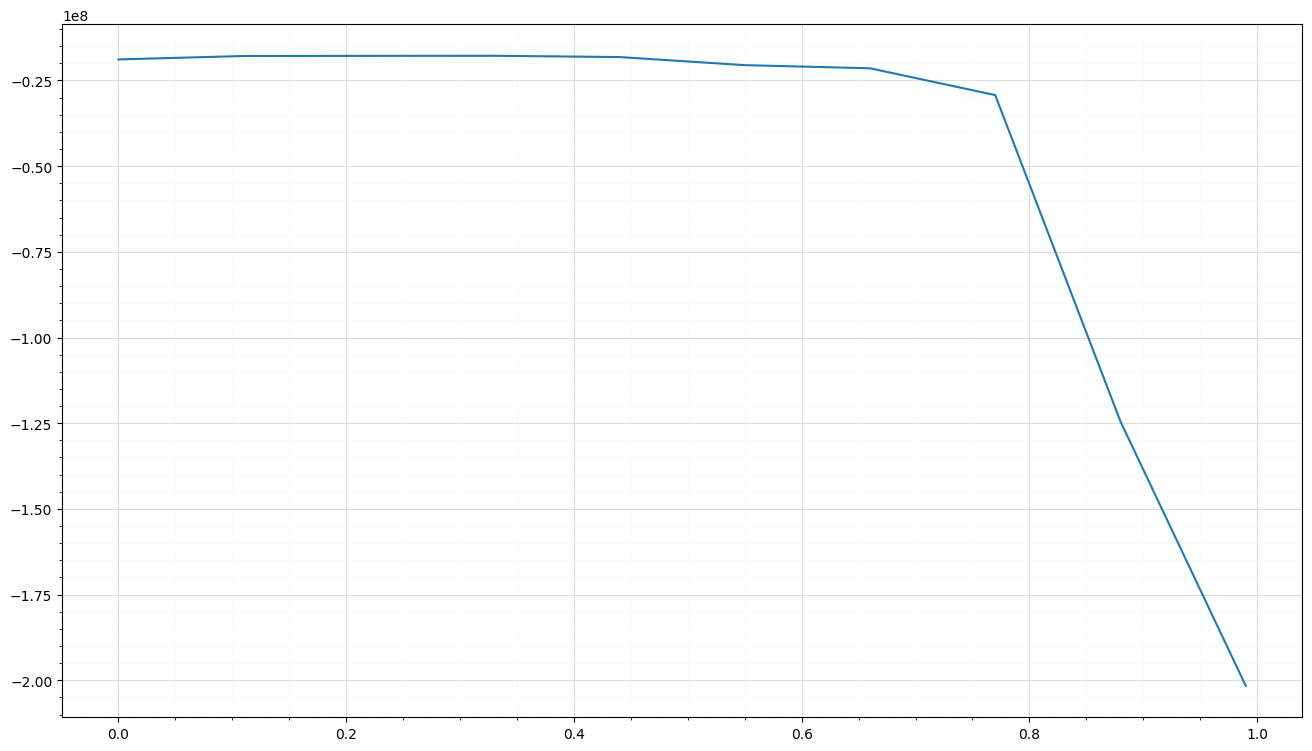

In [17]:
fig1,ax1 = simple_plot(alpha_i,total_loss_vec)